In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
sys.path.append('srcs')
import utils
import dataset
from keras_models import AttentionModel

Using TensorFlow backend.
/home/cenozai/mypy/git/AttentionPdM/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cenozai/mypy/git/AttentionPdM/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cenozai/mypy/git/AttentionPdM/env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

# Settings for data preprocessing

In [2]:
INPUR_DIR = 'data/CMAPSSData'
TASK = 'regression'
WINDOW_SIZE = 30  # scanning window size
FAIL_IN = 14  # turbofan engine fails in 14 cycle
TRAIN_PROPORTION = 3 / 4  # proportion of the training data
CLIP_RUL = 100
MOVING_AVERAGES = []

# Load and preprocess data

In [3]:
os.chdir('../')
data = dataset.TurbofanData(INPUR_DIR)
data.preprocess(clip_RUL=CLIP_RUL, moving_averages=MOVING_AVERAGES)
data.split_train_val(TRAIN_PROPORTION)
if TASK == 'classification':
    arrays = data.arrays_for_classification(WINDOW_SIZE, FAIL_IN)
    train_x, train_y, test_x, test_y, val_x, val_y = arrays
    # one-hot-encoding for classification task
    train_y = utils.one_hot_encode(train_y, num_class)
    test_y = utils.one_hot_encode(test_y, num_class)
    val_y = utils.one_hot_encode(val_y, num_class)
else:
    arrays = data.arrays_for_regression(WINDOW_SIZE)
    train_x, train_y, test_x, test_y, val_x, val_y = arrays

Datasets FD_001, FD_002, FD_003, FD_004 are loaded succesfully!
Finish calculating RUL in FD_001.
Finish calculating RUL in FD_002.
Finish calculating RUL in FD_003.
Finish calculating RUL in FD_004.
Finish normalizing train and test sets.
FD_001: 75 train, 25 validation
FD_002: 195 train, 65 validation
FD_003: 75 train, 25 validation
FD_004: 186 train, 63 validation


# Instantiate model

In [11]:
load_from = 'models/attention/regression_202103311430.h5'
# load_from = 'models/attention/regression_202104041717.h5'
pdm_model = AttentionModel(task=TASK, load_from=load_from)
pdm_model._build_model()

# Plot

In [6]:
def to_array(df, window_size):
    """
    Create and return time series arrays (dependent and independent)
    and a dataframe of RUL and unit number of the corresponding time series.
    """
    unit_grps = df.groupby('unit_number')
    concat_dfs = []
    concat_arrays = []
    for _, unit in unit_grps:
        # create time series array
        # ignore columns of 'unit_number' and 'time'
        array = unit.copy().values[:, 2:]
        num_of_rows = array.shape[0] - window_size + 1
        # sliding window indexer
        indexes = (np.expand_dims(np.arange(window_size), 0) + \
                   np.expand_dims(np.arange(num_of_rows), 0).T)
        array = array[indexes]
        # for j in range(1, len(array)):
        #     compare = array[j][:window_size - 1] == array[j - 1][1:]
        #     assert compare.all(), 'Error in time series array'
        concat_arrays.append(array)
        # create dataframe corresponding to the time series array
        unit_df = unit.iloc[window_size - 1:][['RUL', 'unit_number']]
        concat_dfs.append(unit_df)

    array = np.concatenate(concat_arrays)
    # slice the array into independent and dependent data
    x, y = array[:, :, :-1], array[:, :, -1]
    y = np.min(y, axis=-1)
    df_out = pd.concat(concat_dfs, ignore_index=True)
    return x, y, df_out


def plot_prediction(df, cols_data: str, leg: bool = True, height: int = 2,
                    alpha: float = 0.05, markersize: int = None):
    color = {u: 'grey' for u in df['unit_number'].unique()}
    g = sns.PairGrid(data=df, x_vars="RUL", y_vars=cols_data, palette=color,
                     hue="unit_number", height=height, aspect=6)
    g = g.map(plt.plot, markersize=markersize, alpha=alpha)
    g = g.set(xlim=(df['RUL'].max(), df['RUL'].min() - 10))
    if leg:
        g = g.add_legend()

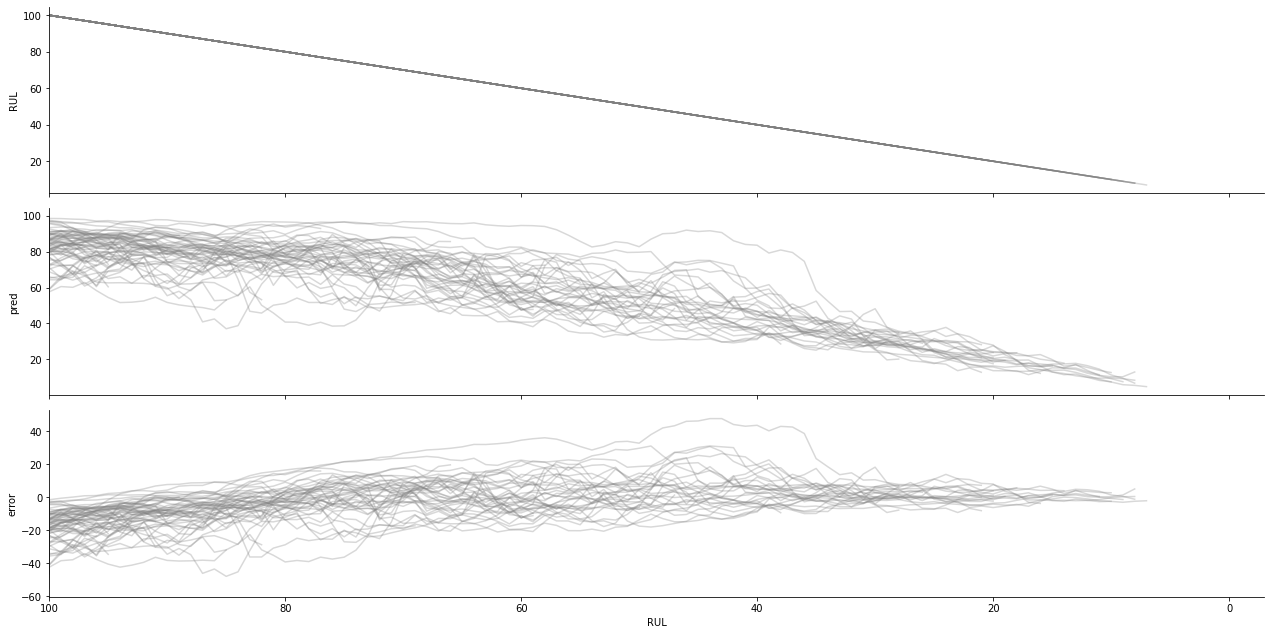

In [12]:
x, y, df_test = to_array(data['FD_001']['df_test'], WINDOW_SIZE)
pred = pdm_model._model.predict(x).flatten()
df = df_test[['RUL', 'unit_number']].copy()
df['error'] = pred - y
df['pred'] = pred
plot_prediction(df, cols_data=['RUL', 'pred', 'error'], leg=False, alpha=0.3, height=3)

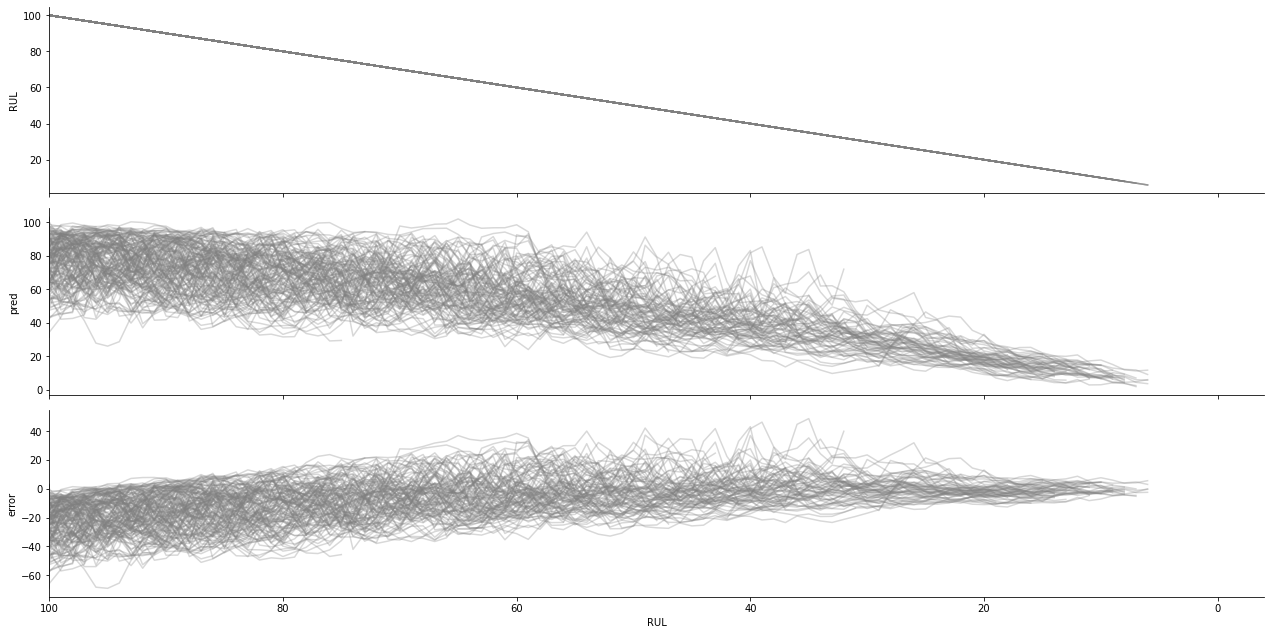

In [13]:
x, y, df_test = to_array(data['FD_002']['df_test'], WINDOW_SIZE)
pred = pdm_model._model.predict(x).flatten()
df = df_test[['RUL', 'unit_number']].copy()
df['error'] = pred - y
df['pred'] = pred
plot_prediction(df, cols_data=['RUL', 'pred', 'error'], leg=False, alpha=0.3, height=3)

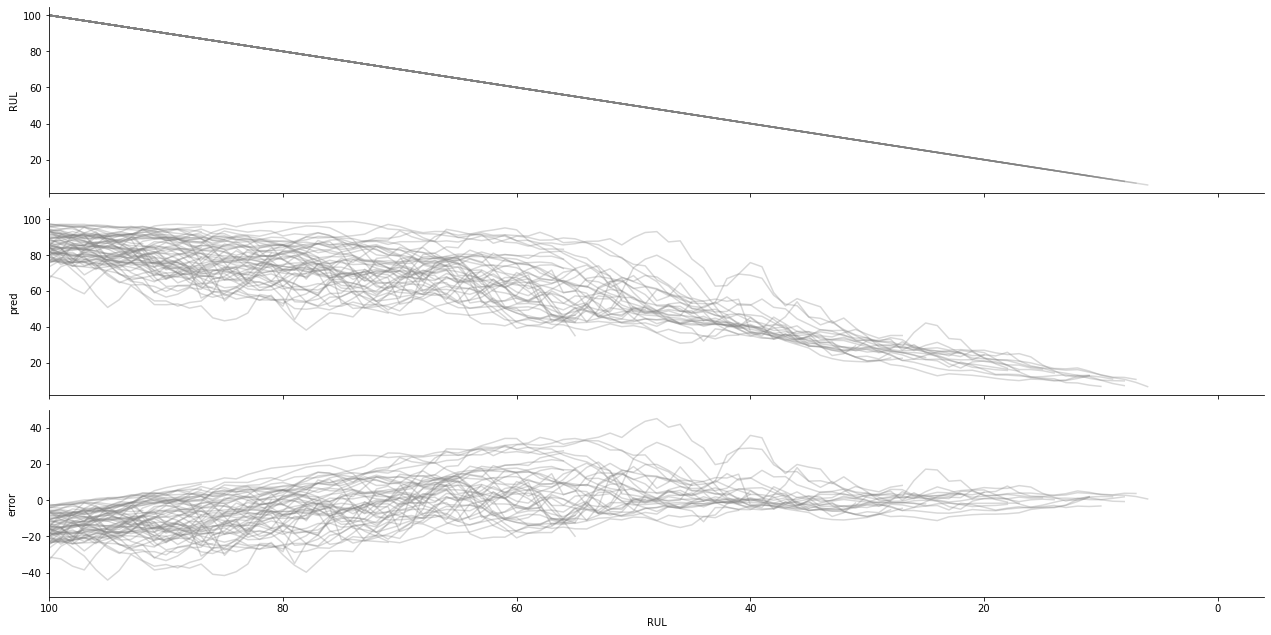

In [14]:
x, y, df_test = to_array(data['FD_003']['df_test'], WINDOW_SIZE)
pred = pdm_model._model.predict(x).flatten()
df = df_test[['RUL', 'unit_number']].copy()
df['error'] = pred - y
df['pred'] = pred
plot_prediction(df, cols_data=['RUL', 'pred', 'error'], leg=False, alpha=0.3, height=3)

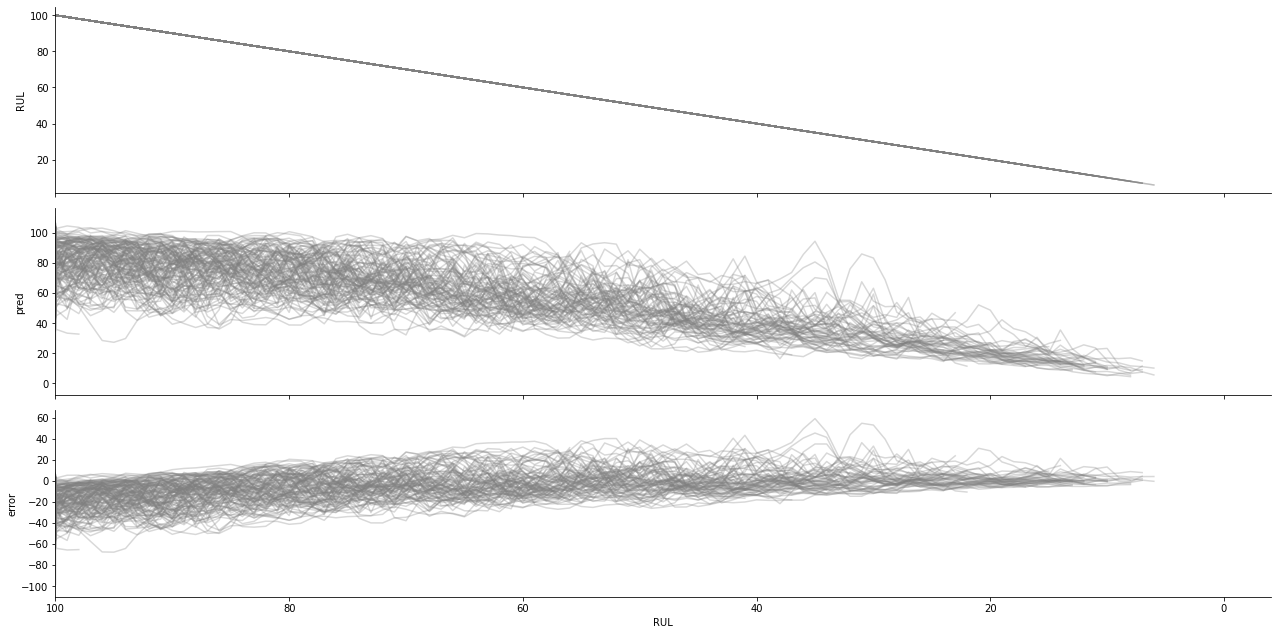

In [15]:
x, y, df_test = to_array(data['FD_004']['df_test'], WINDOW_SIZE)
pred = pdm_model._model.predict(x).flatten()
df = df_test[['RUL', 'unit_number']].copy()
df['error'] = pred - y
df['pred'] = pred
plot_prediction(df, cols_data=['RUL', 'pred', 'error'], leg=False, alpha=0.3, height=3)